This is a trial notebook for approx pipeline and to test models, ignore the data and EDA

In [1]:
import sys

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.compose import make_column_transformer
from sklearn.preprocessing import (
    MinMaxScaler,
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
)

from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# for vizualizing DT
from sklearn.tree import export_graphviz 
import six
sys.modules['sklearn.externals.six'] = six
from sklearn.externals.six import StringIO  
from IPython.display import Image  
import pydotplus

In [2]:
df = pd.read_csv("../species_prediction_model/data/trial_data_riya.csv")
df.head()

,tag_id_long,watershed,river,site,method,local,water_temp_start,species,fork_length_mm,weight_g
0,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,NaN,co,98,NaN
1,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,NaN,co,115,NaN
2,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,NaN,rbt,106,NaN
3,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,co,113,NaN
4,989.001039,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,rbt,81,NaN


In [3]:
df.isnull().sum()

tag_id_long           0
watershed             0
river                 0
site                  0
method                0
local                 0
water_temp_start      3
species               0
fork_length_mm        0
weight_g            100
dtype: int64

In [4]:
df.species.unique()

array(['co', 'rbt'], dtype=object)

This dataset only has 2 labels - co and rbt

In [5]:
for col in df.columns:
    if col not in ['tag_id_long']:
        print(col, ":", df[col].unique())

watershed : ['englishman']
river : ['shelly creek']
site : ['martindale rd']
method : ['smolt trap']
local : ['in-river']
water_temp_start : [ nan  7.   7.8  8.6 10.5 12.  10.6]
species : ['co' 'rbt']
fork_length_mm : [ 98 115 106 113  81  76 100  86  87  91  95  99 101  84  88  89  90 107
 164  93  73  74  80  82  83  85  94  97 104  96 102 105  77 119  92  78]
weight_g : [nan]


In [6]:
df= df.drop(['weight_g', 'tag_id_long'], axis = 1)
df = df.dropna()

In [7]:
df

,watershed,river,site,method,local,water_temp_start,species,fork_length_mm
3,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,co,113
4,englishman,shelly creek,martindale rd,smolt trap,in-river,7.0,rbt,81
5,englishman,shelly creek,martindale rd,smolt trap,in-river,7.8,co,76
6,englishman,shelly creek,martindale rd,smolt trap,in-river,7.8,co,100
7,englishman,shelly creek,martindale rd,smolt trap,in-river,8.6,co,86
...,...,...,...,...,...,...,...,...
95,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,co,100
96,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,co,101
97,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,rbt,78
98,englishman,shelly creek,martindale rd,smolt trap,in-river,10.6,rbt,104


Pipeline 

In [8]:
X = df.drop('species', axis = 1)
y = df['species']

In [9]:
numeric_feats = ["water_temp_start", "fork_length_mm"]  # apply scaling
categorical_feats = ["watershed", "river", "site", "method", "local"]  # apply one-hot encoding
# passthrough_feats = [""]  # do not apply any transformation
# drop_feats = [ "species" ]  
# levels = ["", ""]

In [10]:
ct = make_column_transformer (    
    (StandardScaler(), numeric_feats),  
    #("passthrough", passthrough_feats),     
    (OneHotEncoder(), categorical_feats),  
    #("drop", drop_feats), 
    #OrdinalEncoder(categories=[levels], dtype=int)
)

In [11]:
transformed = ct.fit_transform(X)

In [12]:
column_names = (
    numeric_feats
    # + passthrough_feats    
    + ct.named_transformers_["onehotencoder"].get_feature_names_out().tolist()
)
column_names

['water_temp_start',
 'fork_length_mm',
 'watershed_englishman',
 'river_shelly creek',
 'site_martindale rd',
 'method_smolt trap',
 'local_in-river']

In [13]:
X_transformed = pd.DataFrame(transformed, columns=column_names)
X_transformed.head()

,water_temp_start,fork_length_mm,watershed_englishman,river_shelly creek,site_martindale rd,method_smolt trap,local_in-river
0,-2.820605,1.997771,1.0,1.0,1.0,1.0,1.0
1,-2.820605,-0.831189,1.0,1.0,1.0,1.0,1.0
2,-2.194879,-1.273214,1.0,1.0,1.0,1.0,1.0
3,-2.194879,0.848506,1.0,1.0,1.0,1.0,1.0
4,-1.569153,-0.389164,1.0,1.0,1.0,1.0,1.0


Dummy model

In [14]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_transformed, y)
dummy_clf.score(X_transformed, y)

0.8247422680412371

Decision tree

In [15]:
decision_tree = DecisionTreeClassifier() 
decision_tree.fit(X_transformed, y) 
decision_tree.score(X_transformed, y)

0.9484536082474226

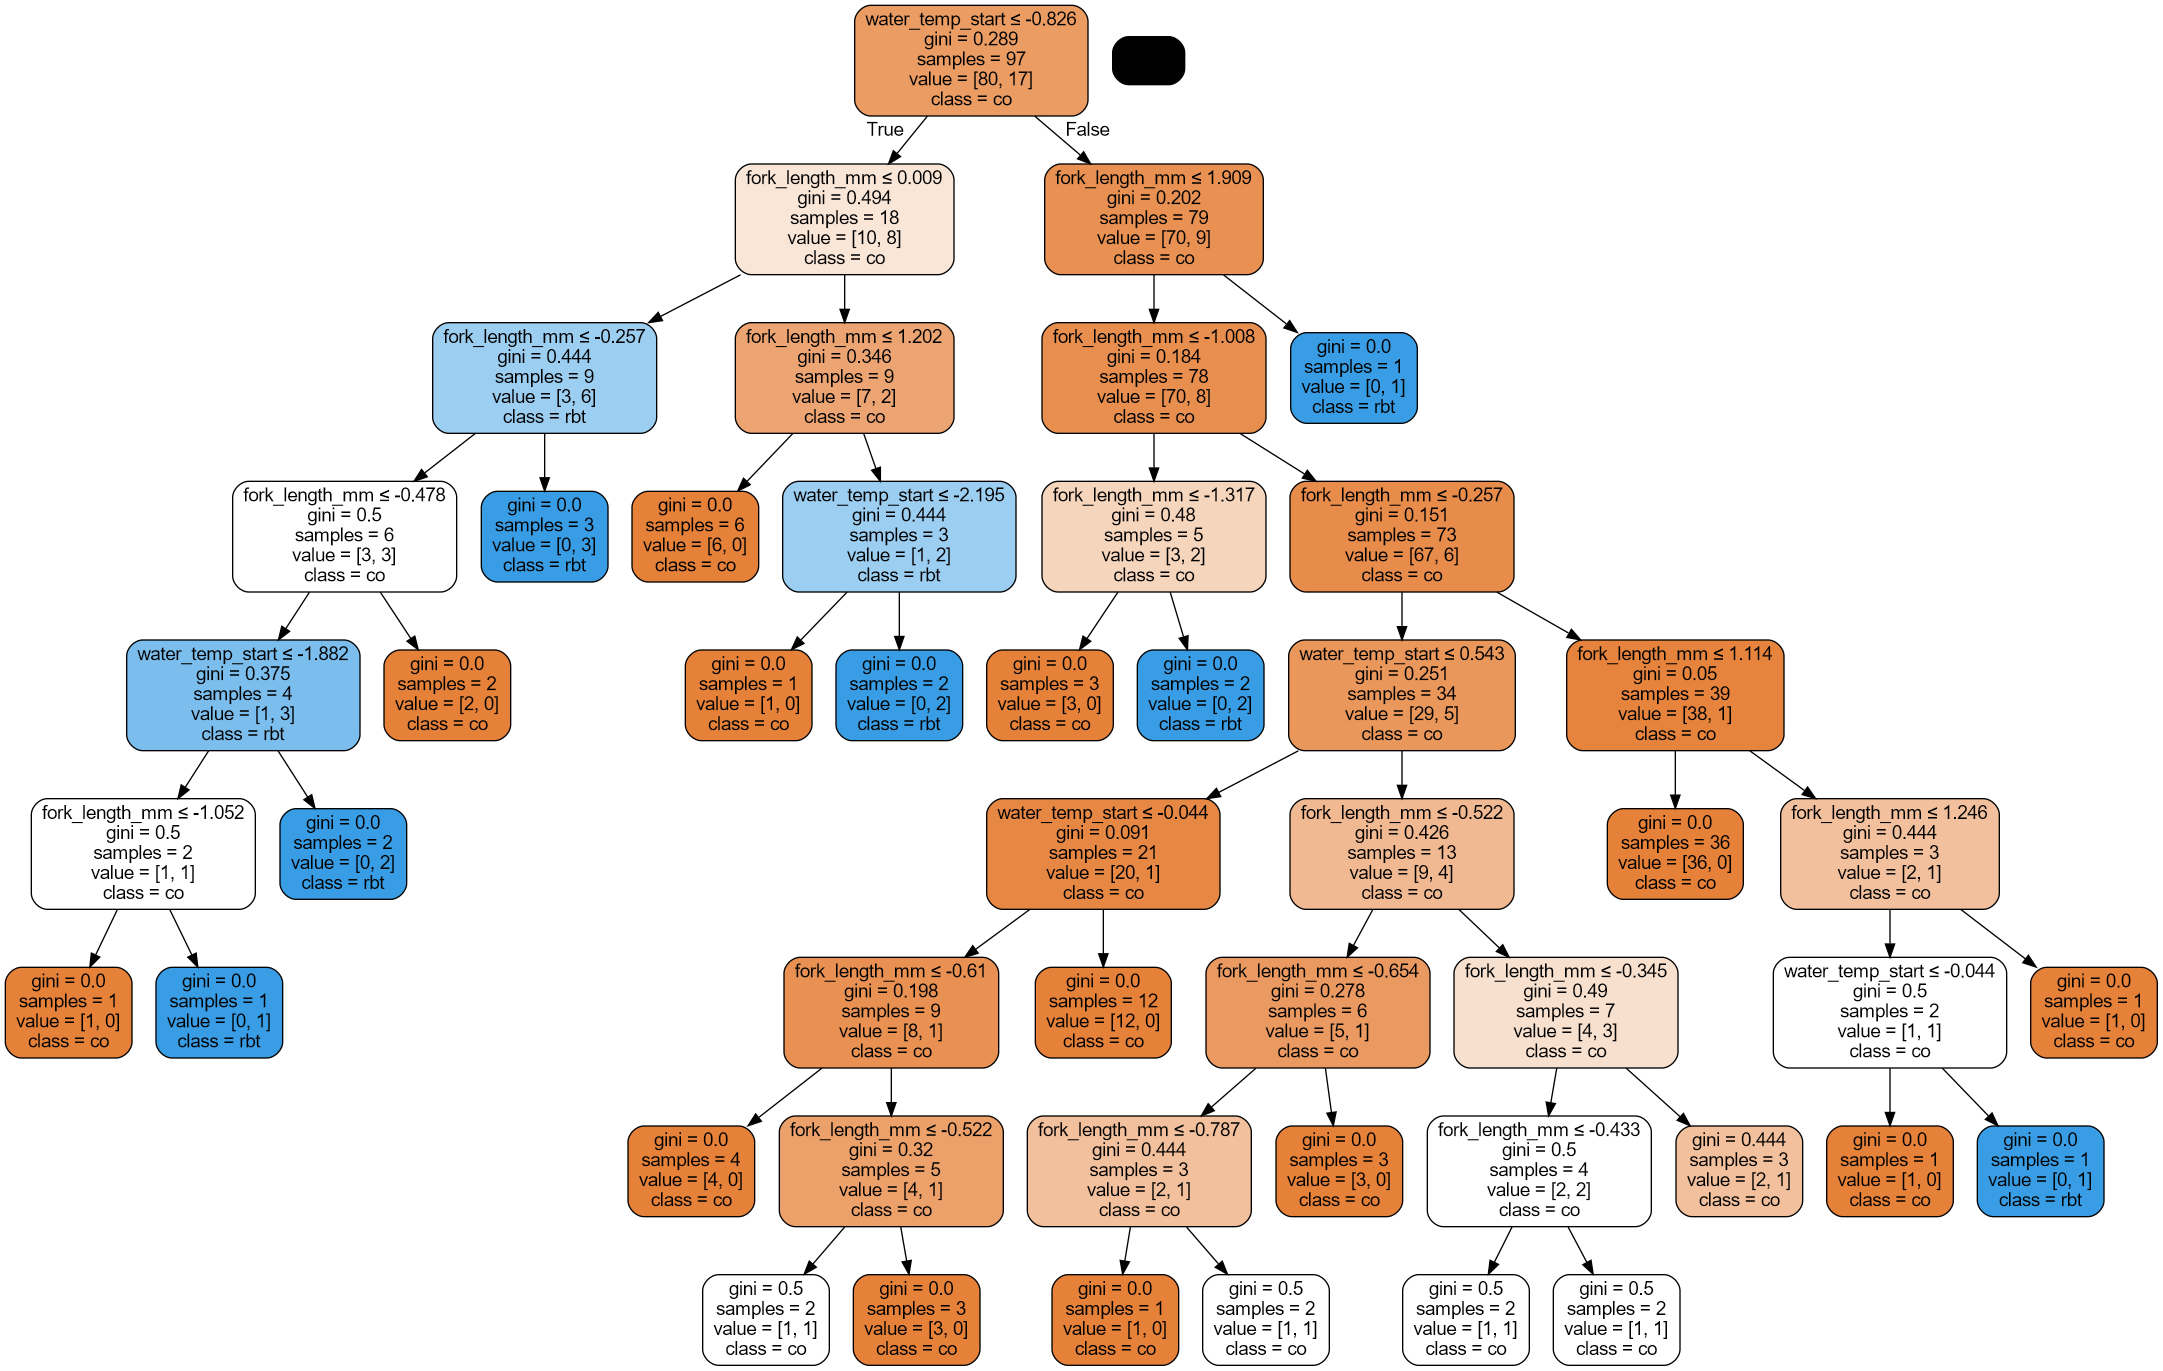

In [19]:
dot_data = StringIO()
export_graphviz(decision_tree, out_file = dot_data, filled = True, 
                rounded = True, 
                special_characters = True,
                feature_names = column_names,
                class_names = ["co", "rbt"])
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png("Decision_tree.png")
Image(graph.create_png())

Mobile net